### Part 1

In [708]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.stats import norm

In [709]:
"""Args:
    S (float): underlying spot price
    K (float): strike price
    r (float): continuous risk free rate
    vol (float): return volatility
    P (float) : price of option
    T (float): time to expiry 
"""

d1 = lambda S, K, r, vol, T: (np.log(S/K) + (r + (vol**2) / 2) * T) / (vol * np.sqrt(T))
d2 = lambda S, K, r, vol, T: d1(S, K, r, vol, T) - vol * np.sqrt(T)

vega = lambda S, K, r, vol, T: S * np.sqrt(T) * norm.pdf(d1(S, K, r, vol, T))

price = lambda S, K, r, vol, T, is_call: (S * norm.cdf(d1(S, K, r, vol, T)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, r, vol, T))
    if is_call else
    K * np.exp(-r * T) * norm.cdf(-d2(S, K, r, vol, T)) - S * norm.cdf(-d1(S, K, r, vol, T)))

In [710]:
def bisection(P, S, K, r, T, tol = 1e-6, is_call = True):
    
    v_a, v_b = 0.0001, 10   #vol limits 
    mid = (v_a + v_b)/2 

    while abs(price(S, K, r, mid, T, is_call) - P) > tol:
        mid = (v_a + v_b)/2
        f_v = price(S, K, r, mid, T, is_call) - P

        if (f_v > 0):
            v_b = mid
        else:
            v_a = mid

        if abs(v_b - v_a) < tol: 
            break
            
    return mid

In [711]:
def newton(P, S, K, r, T, tol = 1e-6, max_iter = 100, is_call = True):
    
    v = 0.5 #intial assumption for vol

    for i in range(max_iter):

        diff = price(S, K, r, v, T, is_call) - P
        
        if vega(S, K, r, v, T) == 0:
            break

        if abs(diff) < tol:
            return v

        v -= diff/vega(S, K, r, v, T)

    return v

In [712]:
print(bisection(5, 45, 50, 0.08, 2.5, is_call = True))

print(newton(5, 45, 50, 0.08, 2.5, is_call = True))

0.0905711974442005
0.09057069417955643


### Part 2

In [714]:
df = pd.read_csv("aapl_eod_202112.txt", delimiter=",") 
df.columns = df.columns.str.strip()
df = df[["[QUOTE_DATE]", "[UNDERLYING_LAST]", "[EXPIRE_DATE]","[STRIKE]", "[C_IV]", "[P_IV]", "[C_BID]", "[C_ASK]", "[P_ASK]", "[P_BID]"]]
df.head()

,[QUOTE_DATE],[UNDERLYING_LAST],[EXPIRE_DATE],[STRIKE],[C_IV],[P_IV],[C_BID],[C_ASK],[P_ASK],[P_BID]
0,2021-12-01,164.68,2021-12-03,100.0,4.040220,1.846840,64.5,65.85,0.01,0.0
1,2021-12-01,164.68,2021-12-03,105.0,3.586530,1.676550,59.5,60.85,0.01,0.0
2,2021-12-01,164.68,2021-12-03,110.0,3.175240,1.513030,54.5,55.85,0.01,0.0
3,2021-12-01,164.68,2021-12-03,115.0,2.786620,1.357350,49.5,50.80,0.01,0.0
4,2021-12-01,164.68,2021-12-03,120.0,2.386700,1.206630,44.5,45.60,0.01,0.0


In [715]:
# Filtering for one quote date i.e 1st Dec 2021
df["[QUOTE_DATE]"] = df["[QUOTE_DATE]"].str.strip()
df = df.loc[df["[QUOTE_DATE]"] == '2021-12-01']

# Filtering for one expiry date i.e June 2022
df["[EXPIRE_DATE]"].unique() 
df["[EXPIRE_DATE]"] = df["[EXPIRE_DATE]"].str.strip()
df = df.loc[df["[EXPIRE_DATE]"] == '2022-06-17']

In [716]:
# Updating IV using the condition of OTM option
df.loc[df["[UNDERLYING_LAST]"] < df["[STRIKE]"], "IV"] = df["[C_IV]"]
df.loc[df["[UNDERLYING_LAST]"] > df["[STRIKE]"], "IV"] = df["[P_IV]"]

# Filtering one underlying price
df["[UNDERLYING_LAST]"].unique() 
df = df.loc[df["[UNDERLYING_LAST]"] == 164.68]
df.head()

,[QUOTE_DATE],[UNDERLYING_LAST],[EXPIRE_DATE],[STRIKE],[C_IV],[P_IV],[C_BID],[C_ASK],[P_ASK],[P_BID],IV
503,2021-12-01,164.68,2022-06-17,28.75,,0.827530,135.75,136.10,0.04,0.01,0.827530
504,2021-12-01,164.68,2022-06-17,30.00,1.121060,0.821800,133.40,136.75,0.04,0.02,0.821800
505,2021-12-01,164.68,2022-06-17,31.25,0.831570,0.801500,133.30,133.65,0.06,0.00,0.801500
506,2021-12-01,164.68,2022-06-17,32.50,0.747690,0.815470,132.00,132.40,0.07,0.02,0.815470
507,2021-12-01,164.68,2022-06-17,33.75,0.792630,0.776880,130.80,131.15,0.07,0.00,0.776880


In [717]:
#print(df[["[STRIKE]", "[IV]"]].sort_values(by="[STRIKE]"))

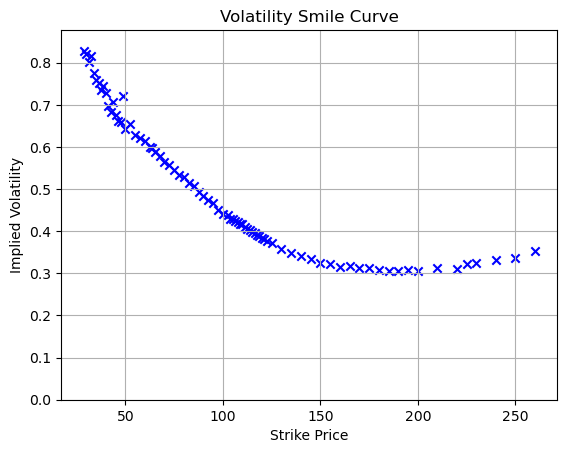

In [718]:
# Converting IV to numeric values
df["IV"] = pd.to_numeric(df["IV"])

# Scatter plot for IV smile curve
plt.scatter(df["[STRIKE]"], df["IV"], marker="x", color="b")
plt.ylim(0, df["IV"].max() + 0.05)         # to start the y axis from 0
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Volatility Smile Curve")
plt.grid(True)
plt.show()

In [719]:
# Optimizing the curve fit using SVI Calibration

# Defining Option price
df["Call_Mid"] = (df["[C_BID]"] + df["[C_ASK]"]) / 2
df["Put_Mid"] = (df["[P_BID]"] + df["[P_ASK]"]) / 2

df.loc[df["[UNDERLYING_LAST]"] < df["[STRIKE]"], "Option_Price"] = df["Call_Mid"]
df.loc[df["[UNDERLYING_LAST]"] > df["[STRIKE]"], "Option_Price"] = df["Put_Mid"]

df["is_call"] = np.where(df["Call_Mid"] == df["Option_Price"], True, False)

df_filtered = df[["[STRIKE]", "Option_Price", "IV", "is_call"]]

df_filtered.head()

,[STRIKE],Option_Price,IV,is_call
503,28.75,0.025,0.82753,False
504,30.00,0.030,0.82180,False
505,31.25,0.030,0.80150,False
506,32.50,0.045,0.81547,False
507,33.75,0.035,0.77688,False


In [720]:
# Constant Declaration

S = 164.8      # Underlying price
r = 0.04       # Assumed risk-free rate
T = 0.5        # 6 months to expiration

# Storing optimized volatilities
optimized_vols = []

# Iterate through each row to calibrate implied volatility
for _, row in df_filtered.iterrows():
    
    K = row["[STRIKE]"]
    option_price = row["Option_Price"]
    is_call = row["is_call"]

    F=lambda v: np.abs(price(S,K,r,v,T,is_call) - option_price)
    
    # Using fmin to minimize the difference between market and model price
    opt_vol = scipy.optimize.fmin(func = F, x0=[0.5])[0]
    
    optimized_vols.append(opt_vol)

# Save implied volatility results
df_filtered.loc[:,"IV_Opt"] = optimized_vols

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

C:\Users\bhanu\AppData\Local\Temp\ipykernel_19256\4258074816.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:,"IV_Opt"] = optimized_vols


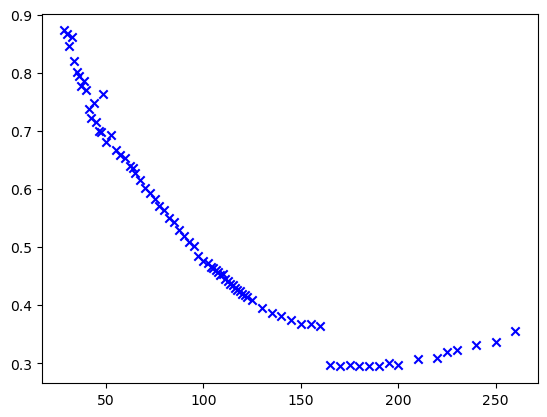

In [721]:
plt.scatter(df_filtered["[STRIKE]"], df_filtered["IV_Opt"], marker="x", color="b")

In [722]:
## SVI Calibration

In [727]:
# Convert strikes to log-moneyness
df_filtered = df_filtered.copy()
df_filtered.loc[:, "log_moneyness"] = np.log(df_filtered["[STRIKE]"] / S)

# SVI Calibration
def svi_objective(params, log_moneyness, iv_squared):
    a, b, rho, m, sigma = params
    model_var = a + b * (rho * (log_moneyness - m) + np.sqrt((log_moneyness - m) ** 2 + sigma ** 2))
    return np.sum((model_var - iv_squared) ** 2)

# Initial guess for SVI parameters
init_params = [0.01, 0.1, -0.5, 0.0, 0.1]

# Total variance (IV^2 * T)
iv_squared = (df_filtered["IV_Opt"] ** 2) * T

# Optimize SVI parameters
res = scipy.optimize.minimize(svi_objective, init_params, args=(df_filtered["log_moneyness"], iv_squared))

# Extract optimal parameters
a_opt, b_opt, rho_opt, m_opt, sigma_opt = res.x

# Compute SVI smoothed variances
df_filtered.loc[:, "SVI_Variance"] = a_opt + b_opt * (rho_opt * (df_filtered["log_moneyness"] - m_opt) + np.sqrt((df_filtered["log_moneyness"] - m_opt) ** 2 + sigma_opt ** 2))

# Compute SVI implied volatility
df_filtered.loc[:, "IV_SVI"] = np.sqrt(df_filtered["SVI_Variance"] / T)

df_filtered

,[STRIKE],Option_Price,IV,is_call,IV_Opt,log_moneyness,SVI_Variance,IV_SVI
503,28.75,0.025,0.82753,False,0.872949,-1.746095,0.373482,0.864270
504,30.00,0.030,0.82180,False,0.866895,-1.703535,0.363487,0.852627
505,31.25,0.030,0.80150,False,0.846484,-1.662713,0.353950,0.841368
506,32.50,0.045,0.81547,False,0.860938,-1.623493,0.344836,0.830465
507,33.75,0.035,0.77688,False,0.820410,-1.585752,0.336113,0.819894
...,...,...,...,...,...,...,...,...
577,225.00,2.015,0.32199,True,0.320312,0.311368,0.048736,0.312204
578,230.00,1.700,0.32369,True,0.322607,0.333347,0.049845,0.315738
579,240.00,1.295,0.33155,True,0.331738,0.375906,0.052738,0.324769
580,250.00,0.945,0.33570,True,0.336743,0.416728,0.056512,0.336189


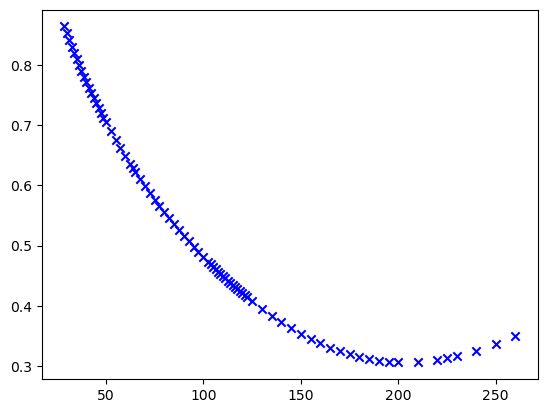

In [747]:
plt.scatter(df_filtered["[STRIKE]"], df_filtered["IV_SVI"], marker="x", color="b")

df_filtered = df_filtered.rename(columns={"[STRIKE]": "strike"})

In [725]:
## Connecting with SQL Database

In [751]:
import psycopg2  

# Establish connection
conn = psycopg2.connect(
    host="localhost", 
    database="Volatility_Calculations",  # Corrected database name format
    user="postgres",  
    password=""  # Add password if required
)

# Create a cursor
cur = conn.cursor()  

# Execute the SQL query
cur.execute("SELECT * FROM public.implied_vol")  

# Fetch all records
records = cur.fetchall()  

# # Iterate over the DataFrame and update the table
# for index, row in df_filtered.iterrows():
#     cur.execute("""
#         INSERT INTO public.implied_vol (strike, iv_opt, iv_svi, iv, option_price)
#         VALUES (%s, %s, %s, %s, %s)
#     """, (row["strike"], row["IV_Opt"], row["IV_SVI"], row["IV"], row["Option_Price"]))

# # Commit changes and close connection
# conn.commit()

# Close cursor and connection
cur.close()  
conn.close()  

# Print the results
print(records)  

[(1, 0.025, 0.8642702495796598, 28.75, 0.82753, 0.8729492187500009), (2, 0.03, 0.8526273813044873, 30.0, 0.8218, 0.8668945312500009), (3, 0.03, 0.841368387977885, 31.25, 0.8015, 0.846484375000001), (4, 0.045000000000000005, 0.8304654082181878, 32.5, 0.81547, 0.8609375000000009), (5, 0.035, 0.8198936294227231, 33.75, 0.77688, 0.820410156250001), (6, 0.035, 0.8096308560889162, 35.0, 0.75922, 0.802050781250001), (7, 0.04, 0.7996571524173139, 36.25, 0.75247, 0.7949218750000009), (8, 0.04, 0.7899545443169196, 37.5, 0.73608, 0.7776367187500008), (9, 0.055, 0.7805067693063632, 38.75, 0.74407, 0.7864257812500008), (10, 0.055, 0.7712990653297296, 40.0, 0.72764, 0.7698242187500007), (11, 0.045, 0.7623179914158158, 41.25, 0.69788, 0.7380859375000006), (12, 0.045, 0.7535512745682333, 42.5, 0.68319, 0.7227539062500005), (13, 0.075, 0.7449876783980015, 43.75, 0.70591, 0.7478515625000006), (14, 0.06, 0.7366168898835062, 45.0, 0.67543, 0.7149414062500007), (15, 0.060000000000000005, 0.7284294213269757